## Notebook 4) Sentiment Analysis

#### Section 4.1: Introduction: 

Initially I wanted to scrap comments from an Interesting LinkedIn post I read about an updated rail transport system on the island of Ireland. It generated a bit of traction on LinkedIn and had a very healthy amount of comments. Unfortunately as I looked further into the topic, scraping these comments violates LinkedIn's user terms and agreements. 

So I then began to research social media sites where I could scrap comments without violating any terms and agreements, and I came to the conclusion that Reddit was my most appropriate choice. 

In [66]:
# Install if neccessary
#pip install praw
#pip install nltk
#pip install wordcloud

In [67]:
import pandas as pd
import praw
import json
import csv
import os
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [68]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

#### Section 4.2: Reddit API

In [69]:
# Create Reddit API object using PRAW
def create_reddit_object(json_file="reddit_config.json", json_key="reddit"):
    with open(json_file) as f:
        data = json.load(f)

    user_values = data[json_key]

    reddit = praw.Reddit(
        client_id=user_values["client_id"],
        client_secret=user_values["client_secret"],
        user_agent=user_values["user_agent"],
        username=user_values["username"],
        password=user_values["password"],
    )
  
    return reddit

In [70]:
# This code just checks the above code has ran successfully
try:
    reddit = create_reddit_object()
    print(f"Authenticated as: {reddit.user.me()}")
except Exception as e:
    print(f"Error: {e}")

Authenticated as: HomeworkDefiant7038


In [71]:
# Outline link to post
post_url = "https://www.reddit.com/r/ireland/comments/17zq2dl/railways_in_ireland_map_showing_the_proposals_of/"

In [72]:
# Create function to scrape comments 
def scrape_comments(post_url, json_file="reddit_config.json", json_key="reddit"):
    reddit = create_reddit_object(json_file, json_key)

    submission = reddit.submission(url=post_url)

    # Print title
    print("Post Title:", submission.title)

    # Print comments
    comments_list = []
    for comment in submission.comments.list():
        comments_list.append(comment.body)
        print(comment.body)
    
    # Create a df
    comments_df = pd.DataFrame({'Comment': comments_list})
    
    return comments_df

In [73]:
# Call the function and capture the df
comments_df = scrape_comments(post_url)

Post Title: Railways in Ireland - Map Showing the Proposals of the All-Island Rail Review
Some really weird gaps in the closed lines that don't make sense to me IMO. Like the small gap preventing Waterford to Cork
Look at that tiny spec of green. Pathetic.
The madness of needing to go through Dublin to get from Galway to Sligo, and from Wexford to Waterford
They really are determined to make sure Donegal has no train.
Mullingar to Athlone line, my heart yearns for you every time I'm in Mullingar station and look through the spooky ghost platform gate 😔

Seriously though, that one line would link up such a lovely chunk of the network.
The entire rail review process needs to think bigger. The idea seems to be to reduce travel times between Dublin and everywhere else on the Island, while integrating with the DART+ expanded light rail system in Dublin. This means Dublin will continue to be the bottleneck. 

A better option would be to introduce a true HSR system from Belfast to Cork, with 

In [74]:
print(comments_df.head())
print(comments_df.shape)

                                             Comment
0  Some really weird gaps in the closed lines tha...
1         Look at that tiny spec of green. Pathetic.
2  The madness of needing to go through Dublin to...
3  They really are determined to make sure Donega...
4  Mullingar to Athlone line, my heart yearns for...
(269, 1)


In [75]:
# Write the df to a CSV file
#comments_df.to_csv("Comments.csv", index=False)

#### Section 4.3: Preprocessing the Data

In [76]:
# I wanted to copy the comment column so that we still have the original comment 
comments_df['Original Comment'] = comments_df['Comment']

In [77]:
# Converting all to lower case
comments_df['Comment'] = comments_df['Comment'].str.lower()

In [78]:
# Removing Special Characters 
comments_df['Comment'] = comments_df['Comment'].str.replace('[^\w\s]', '')

In [79]:
# Tokensise 
comments_df['Comment'] = comments_df['Comment'].apply(word_tokenize)

In [80]:
# Removing Stop Words
stop_words = set(stopwords.words('english'))
comments_df['Comment'] = comments_df['Comment'].apply(lambda x: [word for word in x if word not in stop_words])

In [81]:
# Lemmatisation
lemmatizer = WordNetLemmatizer()
comments_df['Comment'] = comments_df['Comment'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [82]:
# Combine back into Sentences 
comments_df['Comment'] = comments_df['Comment'].apply(lambda x: ' '.join(x))

In [83]:
# Reordering columns
comments_df = comments_df[['Original Comment', 'Comment']]

In [84]:
comments_df

,Original Comment,Comment
0,Some really weird gaps in the closed lines tha...,really weird gap closed line dont make sense i...
1,Look at that tiny spec of green. Pathetic.,look tiny spec green pathetic
2,The madness of needing to go through Dublin to...,madness needing go dublin get galway sligo wex...
3,They really are determined to make sure Donega...,really determined make sure donegal train
4,"Mullingar to Athlone line, my heart yearns for...",mullingar athlone line heart yearns every time...
...,...,...
264,Yep. I tell them my experience and they know b...,yep tell experience know betterideology cult
265,A big spring ejection seat that makes a funny ...,big spring ejection seat make funny booooooooo...
266,I think he might want a 100% guarantee that he...,think might want 100 guarantee wont interface ...
267,Well it's supposed to only be 5-10 minutes acc...,well supposed 510 minute according schedule th...


#### Section 4.4: VADER Sentiment Analysis

In [85]:
# Create new column
comments_df['Compound Sentiment'] = 0  

# Initialise 
Sentiment = SentimentIntensityAnalyzer()

# Analyze sentiment for each comment
for index, row in comments_df.iterrows():
    text = row['Comment']
    sentiment_score = Sentiment.polarity_scores(text)
    
    # Store the compound sentiment score in the 'compound_sentiment' column
    comments_df.at[index, 'Compound Sentiment'] = sentiment_score['compound']

In [86]:
print(comments_df.head())

                                    Original Comment  \
0  Some really weird gaps in the closed lines tha...   
1         Look at that tiny spec of green. Pathetic.   
2  The madness of needing to go through Dublin to...   
3  They really are determined to make sure Donega...   
4  Mullingar to Athlone line, my heart yearns for...   

                                             Comment  Compound Sentiment  
0  really weird gap closed line dont make sense i...              0.1045  
1                      look tiny spec green pathetic             -0.5719  
2  madness needing go dublin get galway sligo wex...             -0.4404  
3          really determined make sure donegal train              0.6436  
4  mullingar athlone line heart yearns every time...              0.7184  


In [87]:
comments_df

,Original Comment,Comment,Compound Sentiment
0,Some really weird gaps in the closed lines tha...,really weird gap closed line dont make sense i...,0.1045
1,Look at that tiny spec of green. Pathetic.,look tiny spec green pathetic,-0.5719
2,The madness of needing to go through Dublin to...,madness needing go dublin get galway sligo wex...,-0.4404
3,They really are determined to make sure Donega...,really determined make sure donegal train,0.6436
4,"Mullingar to Athlone line, my heart yearns for...",mullingar athlone line heart yearns every time...,0.7184
...,...,...,...
264,Yep. I tell them my experience and they know b...,yep tell experience know betterideology cult,0.2960
265,A big spring ejection seat that makes a funny ...,big spring ejection seat make funny booooooooo...,0.1779
266,I think he might want a 100% guarantee that he...,think might want 100 guarantee wont interface ...,0.3182
267,Well it's supposed to only be 5-10 minutes acc...,well supposed 510 minute according schedule th...,0.9043


In [88]:
# Determine polarity based on compound score 
comments_df['Polarity'] = pd.cut(comments_df['Compound Sentiment'],
                                 bins=[float('-inf'), -0.05, 0.05, float('inf')],
                                 labels=['Negative', 'Neutral', 'Positive'],
                                 include_lowest=True)

In [89]:
# Quick check
comments_df['Polarity'].unique()

['Positive', 'Negative', 'Neutral']
Categories (3, object): ['Negative' < 'Neutral' < 'Positive']

In [90]:
comments_df

,Original Comment,Comment,Compound Sentiment,Polarity
0,Some really weird gaps in the closed lines tha...,really weird gap closed line dont make sense i...,0.1045,Positive
1,Look at that tiny spec of green. Pathetic.,look tiny spec green pathetic,-0.5719,Negative
2,The madness of needing to go through Dublin to...,madness needing go dublin get galway sligo wex...,-0.4404,Negative
3,They really are determined to make sure Donega...,really determined make sure donegal train,0.6436,Positive
4,"Mullingar to Athlone line, my heart yearns for...",mullingar athlone line heart yearns every time...,0.7184,Positive
...,...,...,...,...
264,Yep. I tell them my experience and they know b...,yep tell experience know betterideology cult,0.2960,Positive
265,A big spring ejection seat that makes a funny ...,big spring ejection seat make funny booooooooo...,0.1779,Positive
266,I think he might want a 100% guarantee that he...,think might want 100 guarantee wont interface ...,0.3182,Positive
267,Well it's supposed to only be 5-10 minutes acc...,well supposed 510 minute according schedule th...,0.9043,Positive


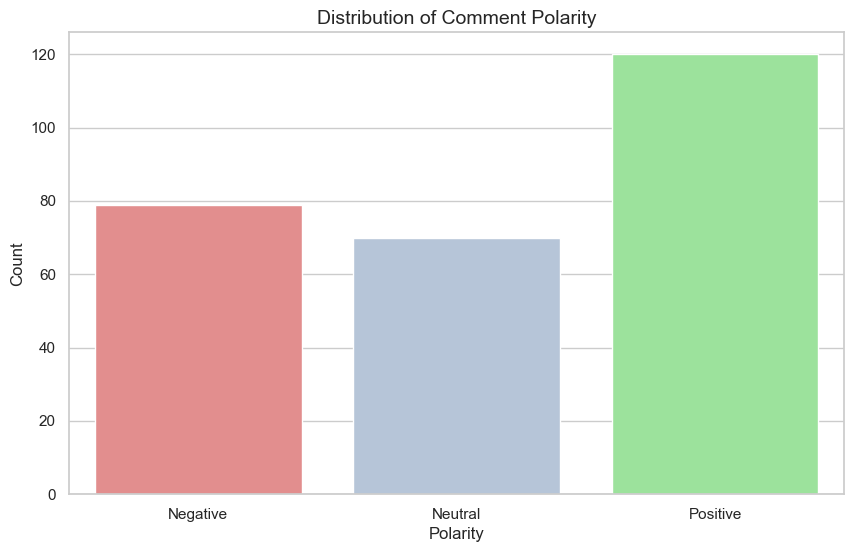

In [98]:
# Plot Graph
sns.set(style="whitegrid")
colors = {'Negative': 'lightcoral','Neutral': 'lightsteelblue','Positive': 'lightgreen'} 
plt.figure(figsize=(10, 6))
sns.countplot(x='Polarity', data=comments_df, palette=colors)
plt.title('Distribution of Comment Polarity', size = 14)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

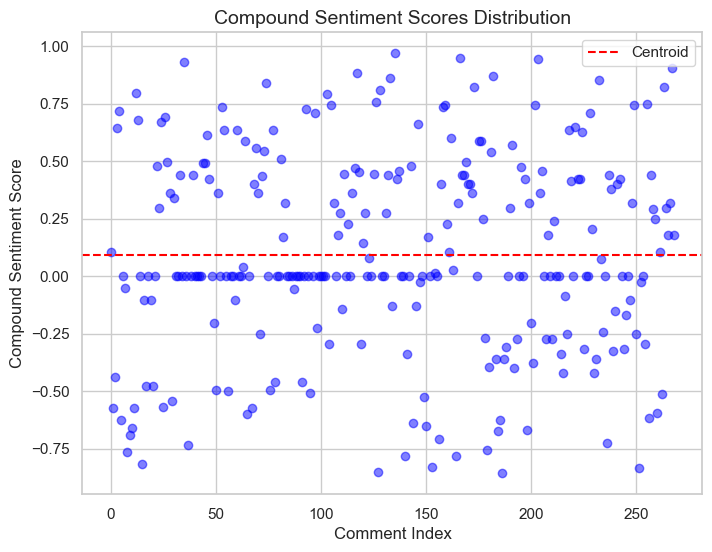

In [105]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(comments_df.index, comments_df['Compound Sentiment'], c='blue', alpha=0.5)

# Calculate and plot centroid
centroid = comments_df['Compound Sentiment'].mean()
plt.axhline(y=centroid, color='red', linestyle='--', label='Centroid')

# Title and axis' 
plt.title('Compound Sentiment Scores Distribution', size = 14)
plt.xlabel('Comment Index')
plt.ylabel('Compound Sentiment Score')
plt.legend()
plt.show()

In [106]:
# Write the df to a CSV file
#comments_df.to_csv("Comments_2.csv", index=False)

#### Section 4.5: Self-Assessment of Model

I understand this this is subjective but I was very curious as to how the model compares to my own judgement. So I downloaded the results to a CSV file and went through each comment and categorised it as Positive, Negative or Neutral based on my own independent judgement. 

As a disclaimer this is not a test for how well the model works and can be thought of as an exercise to satisfy my curiousity. 

In [114]:
# Read in data 
df = pd.read_csv('Comments_Self_Assessment.csv')
df.head(5)

,Original Comment,Comment,Compound Sentiment,Polarity,My Opinion
0,Some really weird gaps in the closed lines tha...,really weird gap closed line dont make sense i...,0.1045,Positive,Negative
1,Look at that tiny spec of green. Pathetic.,look tiny spec green pathetic,-0.5719,Negative,Negative
2,The madness of needing to go through Dublin to...,madness needing go dublin get galway sligo wex...,-0.4404,Negative,Negative
3,They really are determined to make sure Donega...,really determined make sure donegal train,0.6436,Positive,Negative
4,"Mullingar to Athlone line, my heart yearns for...",mullingar athlone line heart yearns every time...,0.7184,Positive,Negative


In [115]:
# Testing model against my categoristation
accuracy = accuracy_score(df['Polarity'], df['My Opinion'])
print(f"Model Accuracy against my Opinion: {accuracy:.2%}")

Model Accuracy against my Opinion: 62.08%


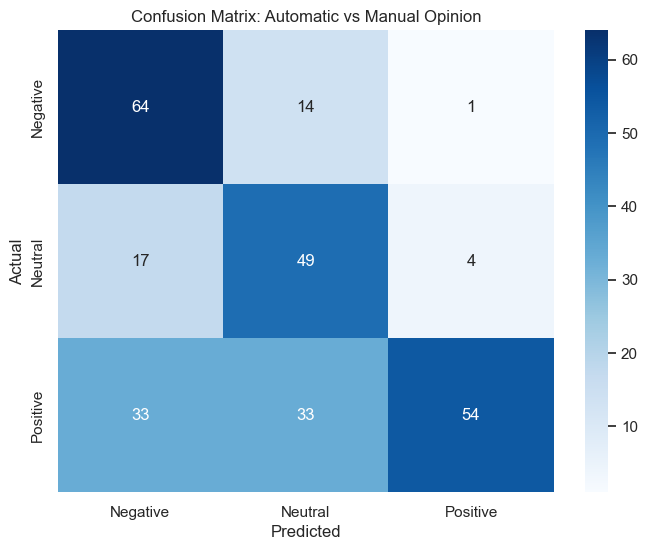

In [116]:
# Confusion Matrix
conf_matrix = confusion_matrix(df['Polarity'], df['My Opinion'], labels=['Negative', 'Neutral', 'Positive'])

# Create a new df
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title('Confusion Matrix: Automatic vs Manual Opinion')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

I won't spend too much time on this section given it's subjectivity but I beleive it is quite interesting. 

#### Section 4.6: Word Cloud

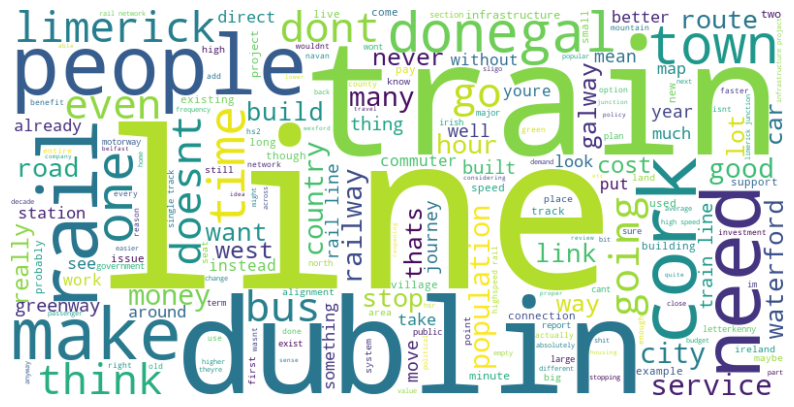

In [117]:
# Joining 
text_data = ' '.join(df['Comment'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display 
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [118]:
# Table displaying word counts
word_counts = wordcloud.process_text(text_data)
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(10)
print(word_counts_df)

,Word,Count
4,line,85
28,train,65
21,dublin,41
91,people,39
48,rail,38
51,need,37
12,cork,36
6,make,32
27,donegal,29
89,town,28


People seem to love talking about Donegal's lack of railways, which was actually a point I brought up earlier. 

The End